In [2]:
from glob import glob

import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.linear_model import LinearRegression, Ridge 
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

In [ ]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400_000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)

    # Drop features with high null counts
    df.drop(columns=["floor", "expenses"], inplace=True)

    # Drop low- and high- cardinality categorical variables
    df.drop(columns=["operation", "properati_url", "currency", "property_type"], inplace=True)

    # Drop leaky columns
    df.drop(columns=["price", "price_aprox_local_currency", "price_per_m2", "price_usd_per_m2"], inplace=True)

    # Drop columns with multicollinearity
    df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)
    

    return df

In [4]:
files = glob(r"C:\Users\Johnt\Downloads\buenos-aires-real-estate-*.csv")
files

['C:\\Users\\Johnt\\Downloads\\buenos-aires-real-estate-1.csv',
 'C:\\Users\\Johnt\\Downloads\\buenos-aires-real-estate-2.csv',
 'C:\\Users\\Johnt\\Downloads\\buenos-aires-real-estate-3.csv',
 'C:\\Users\\Johnt\\Downloads\\buenos-aires-real-estate-4.csv',
 'C:\\Users\\Johnt\\Downloads\\buenos-aires-real-estate-5.csv']

In [5]:
assert len(files) == 5, f"`files` should contain 5 items, not {len(files)}"

In [6]:
# Use a list comprehension to create a list of dataframes
# The for loop
# frames = []
# for file in files:
#     df = wrangle(file)
#     frames.append(df)

frames = [wrangle(file) for file in files]

In [7]:
frames[0].head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
4,129000.0,70.0,-34.584651,-58.454693,Chacarita
9,87000.0,42.0,-34.638979,-58.500115,Villa Luro
29,118000.0,54.0,-34.615847,-58.459957,Caballito
40,57000.0,42.0,-34.625222,-58.382382,Constitución
41,90000.0,50.0,-34.610610,-58.412511,Once


In [8]:
# check the work
assert len(frames) == 5, f"`frames` should contain 5 items, not {len(frames)}"

assert all(
    [isinstance(frame, pd.DataFrame) for frame in frames]
), "The items in `frames` should all be DataFrames."

In [9]:
df = pd.concat(frames, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,129000.0,70.0,-34.584651,-58.454693,Chacarita
1,87000.0,42.0,-34.638979,-58.500115,Villa Luro
2,118000.0,54.0,-34.615847,-58.459957,Caballito
3,57000.0,42.0,-34.625222,-58.382382,Constitución
4,90000.0,50.0,-34.610610,-58.412511,Once


In [10]:
# alternatively the above code can be written as this:
# df = pd.concat([wrangle(file) for file in files], ignore_index=True)
# print(df.info())
# df.head()

In [11]:
# check the work
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"

assert df.shape[1] <= 17, f"`df` has too many columns: {df.shape[1]}"

EXPLORE

In [12]:
df.isnull().sum()

price_aprox_usd            0
surface_covered_in_m2      0
lat                      266
lon                      266
neighborhood               0
dtype: int64

In [13]:
df.isnull().sum() / len(df)

price_aprox_usd          0.000000
surface_covered_in_m2    0.000000
lat                      0.040413
lon                      0.040413
neighborhood             0.000000
dtype: float64

71.13% and 73.58% of the floor and expenses data are missing respectively. Therefore, we drop these features here. 

In [14]:
# check the work
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"

assert df.shape[1] <= 15, f"`df` has too many columns: {df.shape[1]}"

In [15]:
# Checking out the number of unique values for each non-numeric feature in df.

# Subset the data based on data type shown here. 
df.select_dtypes("object").head()

,neighborhood
0,Chacarita
1,Villa Luro
2,Caballito
3,Constitución
4,Once


In [16]:
# Checking out the different datatypes present in this subset
df.select_dtypes("object").nunique()

neighborhood    57
dtype: int64

Because the `operation`, `currency` and the `property_type` columns essentially provide just one type of information (i.e. `low cardinality features`), we remove them from the dataset, as they do not feed our model with any particularly new or useful information.

On the other hand, the `properati_url` column with 6582 different unique values is a `high cardinality feature`. If one is to OneHotEncode this feature, there results curse of dimensionality. This does not provide any pattern that our model can learn from. 

Therefore, we are to drop all these columns in the dataset from the wrangle function. 

In [17]:
sorted(df.columns)

['lat', 'lon', 'neighborhood', 'price_aprox_usd', 'surface_covered_in_m2']

We see from here that several columns that point to price are to be removed from the dataset, as they will all constitute `leakage`. So we remove '`price_aprox_local_currency'`, `'price'`,   `'price_per_m2'`,  `'price_usd_per_m2'` columns from our data in order to prevent leakage.

In [18]:
# check the work
assert len(df) == 6582, f"`df`has the wrong number of rows: {len(df)}"

assert df.shape[1] <= 7, f"`df` has too many columns: {df.shape[1]}"

In [19]:
df.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,129000.0,70.0,-34.584651,-58.454693,Chacarita
1,87000.0,42.0,-34.638979,-58.500115,Villa Luro
2,118000.0,54.0,-34.615847,-58.459957,Caballito
3,57000.0,42.0,-34.625222,-58.382382,Constitución
4,90000.0,50.0,-34.610610,-58.412511,Once


In [20]:
df.columns

Index(['price_aprox_usd', 'surface_covered_in_m2', 'lat', 'lon',
       'neighborhood'],
      dtype='object')

In [21]:
# Checking for mullticollineaerity in the features
corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr()

corr

,surface_covered_in_m2,lat,lon
surface_covered_in_m2,1.000000,0.028538,0.034515
lat,0.028538,1.000000,-0.262439
lon,0.034515,-0.262439,1.000000


<Axes: >

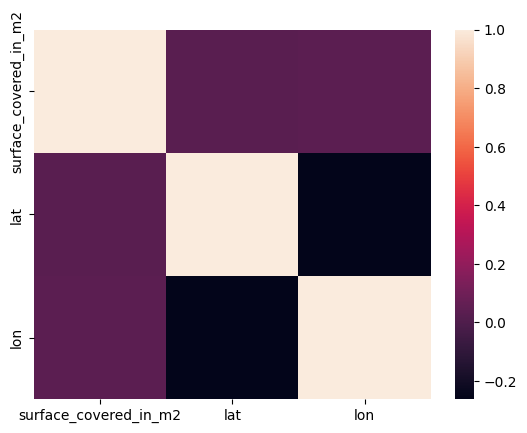

In [22]:
sns.heatmap(corr)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB


Because of the missing values in the `surface_total_in_m2` and `rooms` columns, in addition to their multicollinearity, they should be dropped leaving room for the other features to be used in training the model. 

In [24]:
df.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,129000.0,70.0,-34.584651,-58.454693,Chacarita
1,87000.0,42.0,-34.638979,-58.500115,Villa Luro
2,118000.0,54.0,-34.615847,-58.459957,Caballito
3,57000.0,42.0,-34.625222,-58.382382,Constitución
4,90000.0,50.0,-34.610610,-58.412511,Once


SPLIT DATA

In [38]:
features = ["surface_covered_in_m2", "lat", "lon", "neighborhood"]

X_train = df[features]


In [26]:
target = "price_aprox_usd"

y_train = df[target]


In [27]:
# check the work
assert X_train.shape == (6582, 4), f"`X_train` is the wrong size: {X_train.shape}."

assert y_train.shape == (6582,), f"`y_train` is the wrong size: {y_train.shape}."


BUILD MODEL

Baseline

In [29]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)

print("Mean apt price:", y_mean)

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 132383.83701458524
Baseline MAE: 44860.10834274133


ITERATE

In [30]:
# Create a pipeline
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)

model.fit(X_train, y_train)

c:\Users\Johnt\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\externals\_numpydoc\docscrape.py:420: UserWarning: Unknown section Example
  self[section] = content


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('onehotencoder', ...), ('simpleimputer', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,verbose,0
,cols,['neighborhood']
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,use_cat_names,True


In [31]:
# Check the work
check_is_fitted(model[-1])

EVALUATE

In [32]:
y_pred_training = model.predict(X_train)

mae_training = mean_absolute_error(y_train, y_pred_training)

print("Training MAE:", round(mae_training, 2))


Training MAE: 24207.11


We can infer from this that the model is learning as it outperforms the baseline by approprimately 46%. 

In [42]:
X_test = pd.read_csv(r"C:\Users\Johnt\Downloads\buenos-aires-test-features.csv.csv")[features]

y_pred_test = pd.Series(model.predict(X_test))

y_pred_test.head()

0    231122.403569
1    162572.942392
2     68477.949626
3     63521.438989
4    105694.463885
dtype: float64

In [44]:
y_test = pd.read_csv(r"C:\Users\Johnt\Downloads\buenos-aires-test-features.csv.csv")

y_test.head()

,Unnamed: 0,surface_covered_in_m2,lat,lon,neighborhood
0,1,47,-34.615310,-58.361983,Puerto Madero
1,2,55,-34.547298,-58.462705,Nuñez
2,3,34,-34.617762,-58.383662,Monserrat
3,4,34,-34.639925,-58.438406,Parque Chacabuco
4,5,42,-34.611495,-58.442359,Caballito


COMMUNICATE RESULTS

In [45]:
def make_prediction(area, lat, lon, neighborhood):
# Take input from user and put into dictionary
   data = {
      "surface_covered_in_m2": area,
      "lat": lat,
      "lon": lon,
      "neighborhood": neighborhood
   } 

# Put dictionary into a dataframe   
   df = pd.DataFrame(data, index=[0])

# Feed that into our model to make prediction
   prediction = model.predict(df).round(2)[0]

# Return prediction
   return f"Predicted apartment price: ${prediction}"

In [46]:
# Use the make_prediction function
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $250775.11'

In [48]:
# CREATING A MVP WIDGET TO MAKE PREDICTIONS USING AREA, LAT, LON AND NEIGHBORHOOD

interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…